In [2]:
from data import Data

In [3]:
data_filepath = "data/SC_integration/counts_ctc_simulated_123_5k.tsv"
true_results_filepath = "data/SC_integration/ids_ctc_simulated_123_5k.tsv"
train_indices_filepath = "data/SC_integration/train_indices.npy"
test_indices_filepath = "data/SC_integration/test_indices.npy"

data_object = Data(data_filepath, true_results_filepath)
train_data, test_data, train_true_results, test_true_results =  data_object.load_train_test_split(train_indices_filepath, test_indices_filepath)

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy: 0.996096291476903
Test accuracy: 0.9916540212443096
Number of genes that matter: 43 out of 2000  (2.15%)


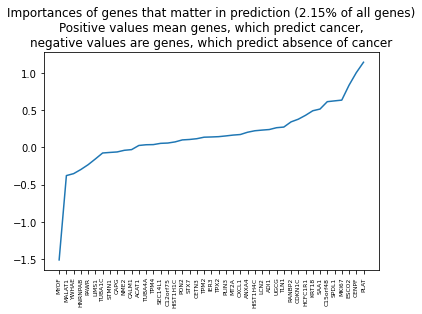

In [7]:
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.config.set_visible_devices([], 'GPU')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

train_data_, test_data_, train_true_results_, test_true_results_=np.array(train_data,np.float32),np.array(test_data,np.float32),np.array(train_true_results,np.int32),np.array(test_true_results,np.int32)


regularization=0.02 #small values mean stronger regularization
clf = LogisticRegression(random_state=0,class_weight='balanced',penalty='l1',C=regularization,solver='liblinear')
clf.fit(train_data_, train_true_results_)
print("Train accuracy: "+str(clf.score(train_data_, train_true_results_)))
print("Test accuracy: "+str(clf.score(test_data_, test_true_results_)))

zipped=sorted(zip(clf.coef_.tolist()[0],train_data.columns.values.tolist()))

importance_threshold=0.02
genes_that_matter=list(filter(lambda x: abs(x[0])>importance_threshold,zipped))
print("Number of genes that matter: "+str(len(genes_that_matter))+" out of "+str(len(zipped))+"  ("+str(100*len(genes_that_matter)/len(zipped))+"%)")

genes_importances=list(zip(*genes_that_matter))#list(zip(*zipped))
plt.plot(genes_importances[1],genes_importances[0])
plt.title("Importances of genes that matter in prediction ("+str(100*len(genes_that_matter)/len(zipped))+"% of all genes)"+"\nPositive values mean genes, which predict cancer,\nnegative values are genes, which predict absence of cancer")
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=6)
plt.show()